## import & merge

In [2]:
import pandas as pd
train_df = pd.read_csv('../data/train/train_ratings.csv')
genres_df = pd.read_csv('../data/train/genres.tsv', sep='\t')
directors_df = pd.read_csv('../data/train/directors.tsv', sep='\t')
writers_df = pd.read_csv('../data/train/writers.tsv', sep='\t')
years_df = pd.read_csv('../data/train/years.tsv', sep='\t')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# merge dataframes

unique_movie = train_df['item'].unique()

genres_df = genres_df.groupby('item')['genre'].apply(list).reset_index()
directors_df = directors_df.groupby('item')['director'].apply(list).reset_index()
writers_df = writers_df.groupby('item')['writer'].apply(list).reset_index()

train_df = pd.merge(train_df, genres_df, on='item', how='left')
train_df = pd.merge(train_df, directors_df, on='item', how='left')
train_df = pd.merge(train_df, writers_df, on='item', how='left')
train_df = pd.merge(train_df, years_df, on='item', how='left')

In [4]:
# time second -> dateime
train_df['time'] = pd.to_datetime(train_df['time'], unit='s')

In [5]:
train_df.head()

,user,item,time,genre,director,writer,year
0,11,4643,2009-01-01 04:02:09,"[Action, Adventure, Drama, Sci-Fi]",[nm0000318],"[nm0099541, nm0115310, nm0465199, nm0742797]",2001.0
1,11,170,2009-01-01 04:02:14,"[Action, Adventure, Crime, Thriller]",[nm0812200],NaN,1995.0
2,11,531,2009-01-01 04:02:19,"[Children, Drama]",[nm0002140],"[nm0003031, nm0122364]",1993.0
3,11,616,2009-01-01 04:02:22,"[Animation, Children]",[nm0718627],"[nm0027011, nm0166307, nm0166551, nm0314788, n...",1970.0
4,11,2140,2009-01-01 04:02:43,"[Adventure, Fantasy]","[nm0000568, nm0001345]","[nm0001345, nm0643973]",1982.0


In [6]:
train_df.describe()

,user,item,time,year
count,5.154471e+06,5.154471e+06,5154471,5.152639e+06
mean,6.875153e+04,1.716849e+04,2009-07-19 15:17:48.336951296,1.993837e+03
min,1.100000e+01,1.000000e+00,2005-04-11 11:56:25,1.922000e+03
25%,3.419900e+04,1.304000e+03,2007-02-01 18:32:53,1.989000e+03
50%,6.860500e+04,3.897000e+03,2009-02-14 22:39:14,1.998000e+03
75%,1.032010e+05,2.671200e+04,2011-10-10 22:01:38.500000,2.004000e+03
max,1.384930e+05,1.191450e+05,2015-03-31 05:50:52,2.014000e+03
std,3.993460e+04,2.633563e+04,NaN,1.527865e+01


## Train DF

In [7]:
# time 1년 단위로 묶기
train_df['view_year'] = train_df['time'].dt.year

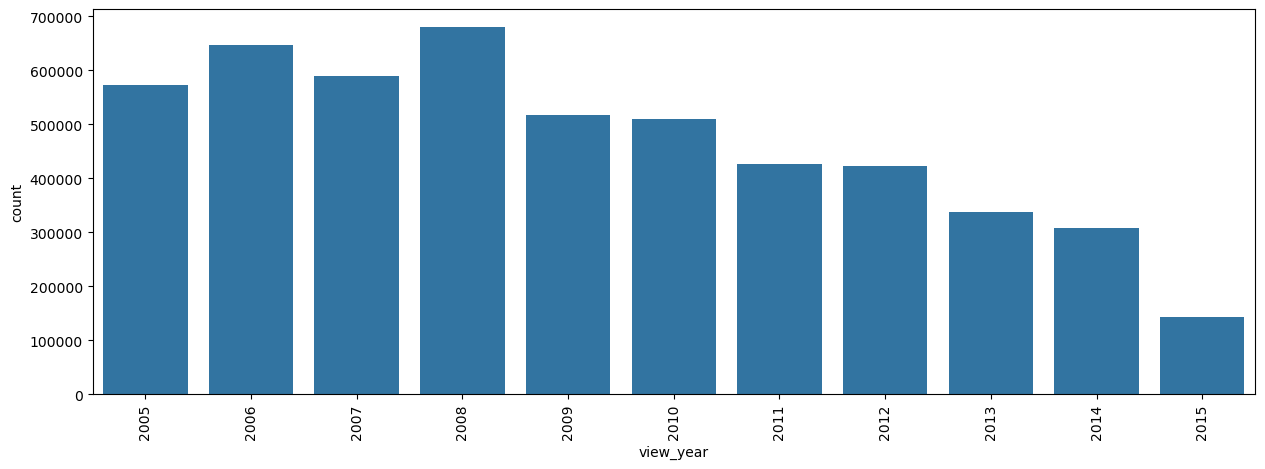

In [8]:
# year별 count plot
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='view_year')
plt.xticks(rotation=90)
plt.show()

특정 시점 이후에 평가된 영화 맞추기 -> 2015년 3월 31일 이후

과거에 평가된 masking된 영화 맞추기 -> 2005 ~ 2015 사이

In [9]:
# 각 영화마다, 연도별로 평가가 몇번 되었는지 DataFrame 생성
year_counts = train_df.groupby(['item', 'view_year']).size().reset_index(name='counts')
year_counts.corr('spearman') # -0.352942

,item,view_year,counts
item,1.000000,0.185441,-0.123216
view_year,0.185441,1.000000,-0.352942
counts,-0.123216,-0.352942,1.000000


In [10]:
year_counts.head()

,item,view_year,counts
0,1,2005,1385
1,1,2006,1518
2,1,2007,1463
3,1,2008,1752
4,1,2009,1166


In [11]:
year_counts = train_df.groupby(['user', 'view_year']).size().reset_index(name='counts')
year_counts.corr(method='spearman') # -0.186381

,user,view_year,counts
user,1.000000,0.001303,-0.003674
view_year,0.001303,1.000000,-0.186381
counts,-0.003674,-0.186381,1.000000


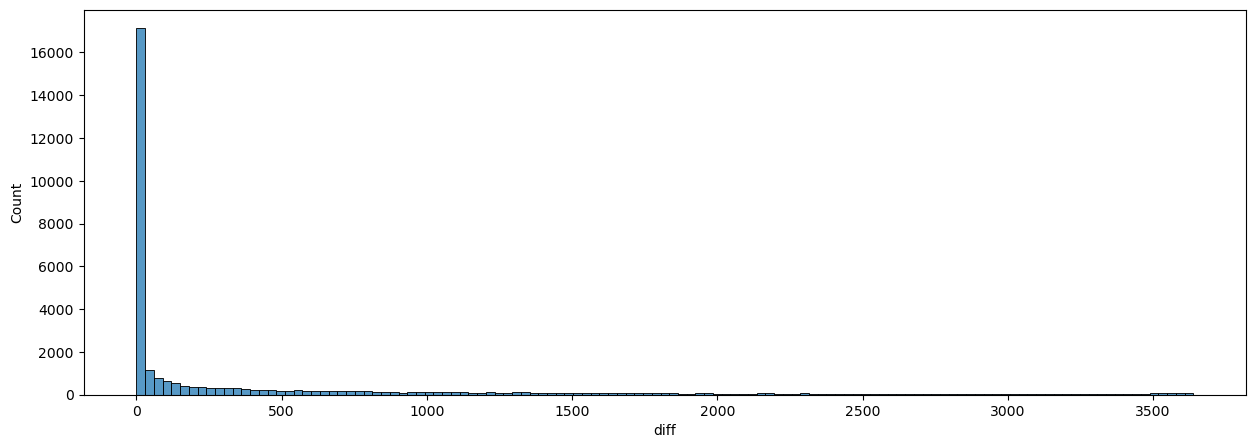

440.09792729591834


In [12]:
# 각 유저마다 최초 평가한 time과 마지막 평가한 time을 구해서, 그 차이를 구함
user_time = train_df.groupby('user')['time'].agg(['min', 'max']).reset_index()
user_time['diff'] = user_time['max'] - user_time['min']
user_time['diff'] = user_time['diff'].dt.days

# plot
plt.figure(figsize=(15, 5))
sns.histplot(user_time['diff'])
plt.show()
print(user_time['diff'].mean())

In [13]:
print(user_time[user_time['diff'] < 1].shape[0])
print(user_time[user_time['diff'] < 1].shape[0] / user_time.shape[0])

11737
0.3742665816326531


하루만에 평가를 끝낸 유저한테 순차적인 특성을 반영하여 추천을 하는 것이 맞을지 고려해야 함.

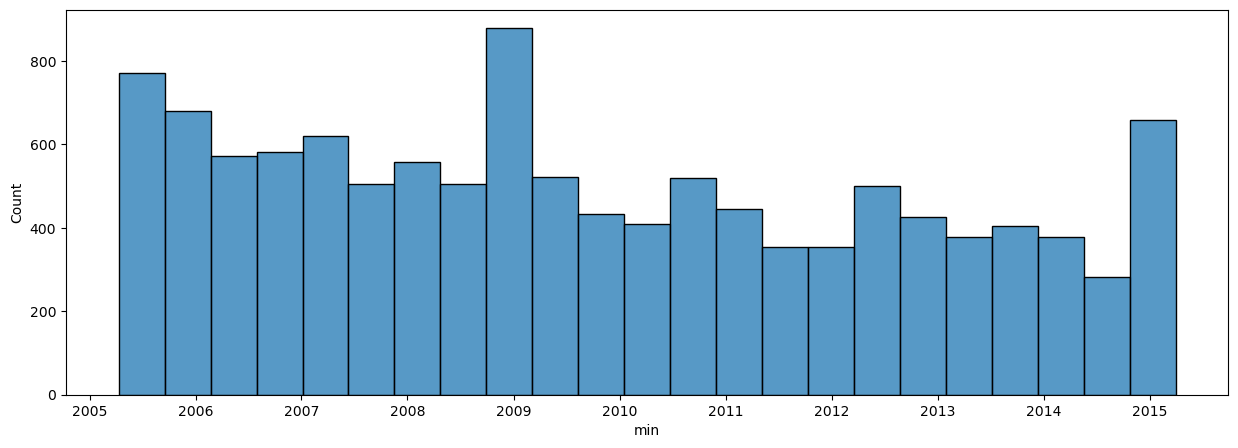

In [14]:
# diff가 1보다 작은 유저의 평가 시작 시간 분포
plt.figure(figsize=(15, 5))
sns.histplot(user_time[user_time['diff'] < 1]['min'])
plt.show()

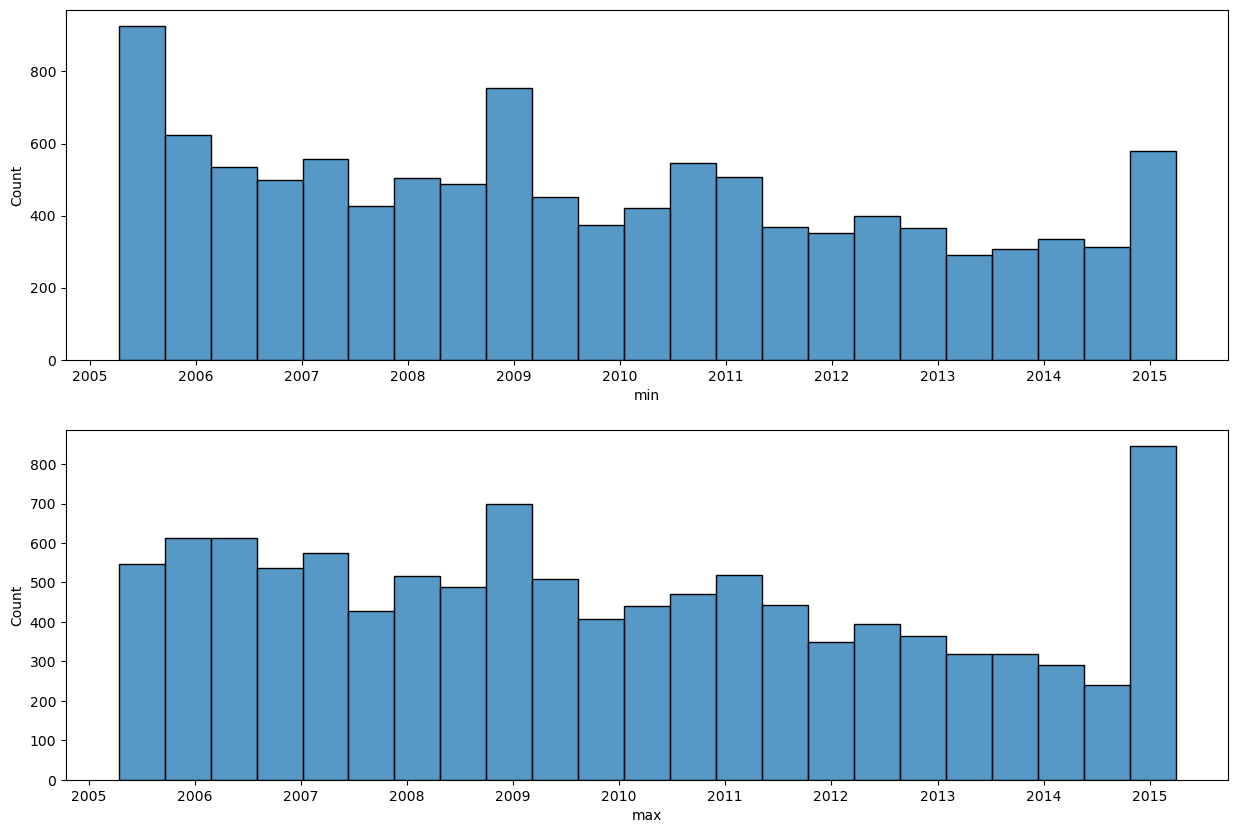

In [15]:
# diff가 1~365 평가 시작 시간 분포
# diff가 1~36₩5 평가 종료 시간 분포

# 세로 2개 subplot
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(user_time[(user_time['diff'] >= 1) & (user_time['diff'] <= 365)]['min'], ax=ax[0])
sns.histplot(user_time[(user_time['diff'] >= 1) & (user_time['diff'] <= 365)]['max'], ax=ax[1])
plt.show()

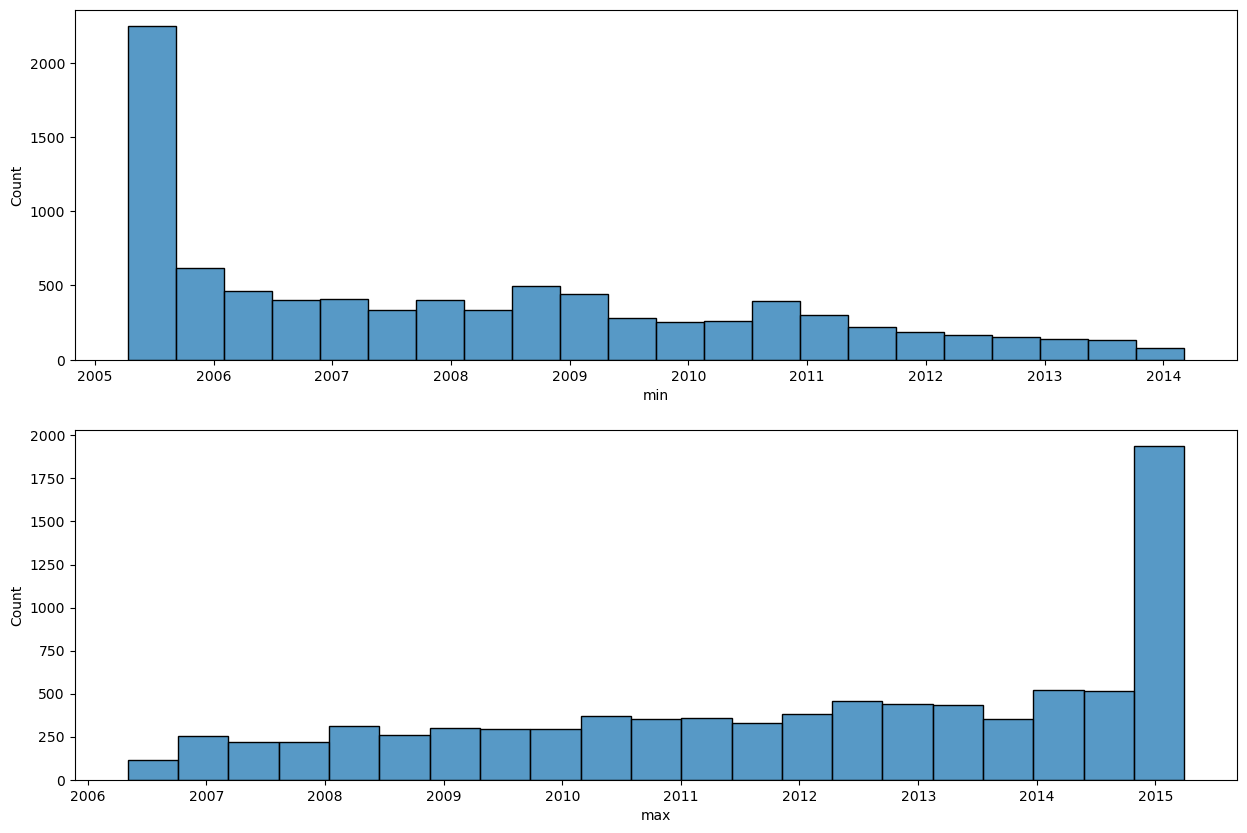

In [16]:
# diff가 365 이상 평가 시작 시간 분포
# diff가 365 이상 평가 종료 시간 분포

# 세로 2개 subplot
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(user_time[user_time['diff'] >= 365]['min'], ax=ax[0])
sns.histplot(user_time[user_time['diff'] >= 365]['max'], ax=ax[1])
plt.show()

## Year

In [17]:
train_df.head()

,user,item,time,genre,director,writer,year,view_year
0,11,4643,2009-01-01 04:02:09,"[Action, Adventure, Drama, Sci-Fi]",[nm0000318],"[nm0099541, nm0115310, nm0465199, nm0742797]",2001.0,2009
1,11,170,2009-01-01 04:02:14,"[Action, Adventure, Crime, Thriller]",[nm0812200],NaN,1995.0,2009
2,11,531,2009-01-01 04:02:19,"[Children, Drama]",[nm0002140],"[nm0003031, nm0122364]",1993.0,2009
3,11,616,2009-01-01 04:02:22,"[Animation, Children]",[nm0718627],"[nm0027011, nm0166307, nm0166551, nm0314788, n...",1970.0,2009
4,11,2140,2009-01-01 04:02:43,"[Adventure, Fantasy]","[nm0000568, nm0001345]","[nm0001345, nm0643973]",1982.0,2009


In [18]:
train_df['year'].min()

1922.0

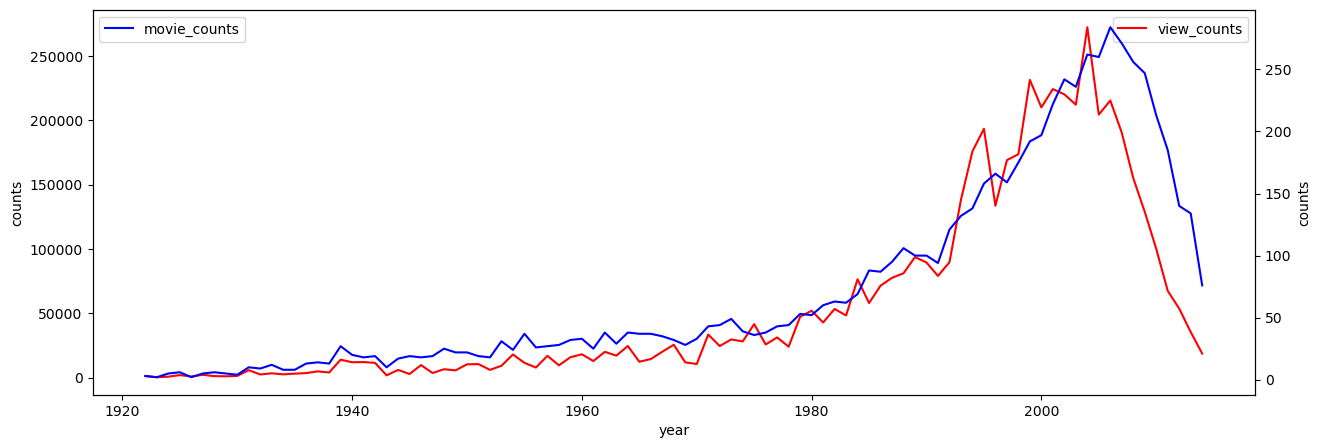

In [19]:
# year 별 평가 수
year_counts = train_df.groupby('year').size().reset_index(name='counts')
# year 별 영화 개수
year_movie_counts = train_df.groupby('year')['item'].nunique().reset_index(name='counts')

# plot
plt.figure(figsize=(15, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
sns.lineplot(data=year_counts, x='year', y='counts', ax=ax1, color='r')
sns.lineplot(data=year_movie_counts, x='year', y='counts', ax=ax2, color='b')
ax1.legend(['view_counts'])
ax2.legend(['movie_counts'])
plt.show()

## Genre

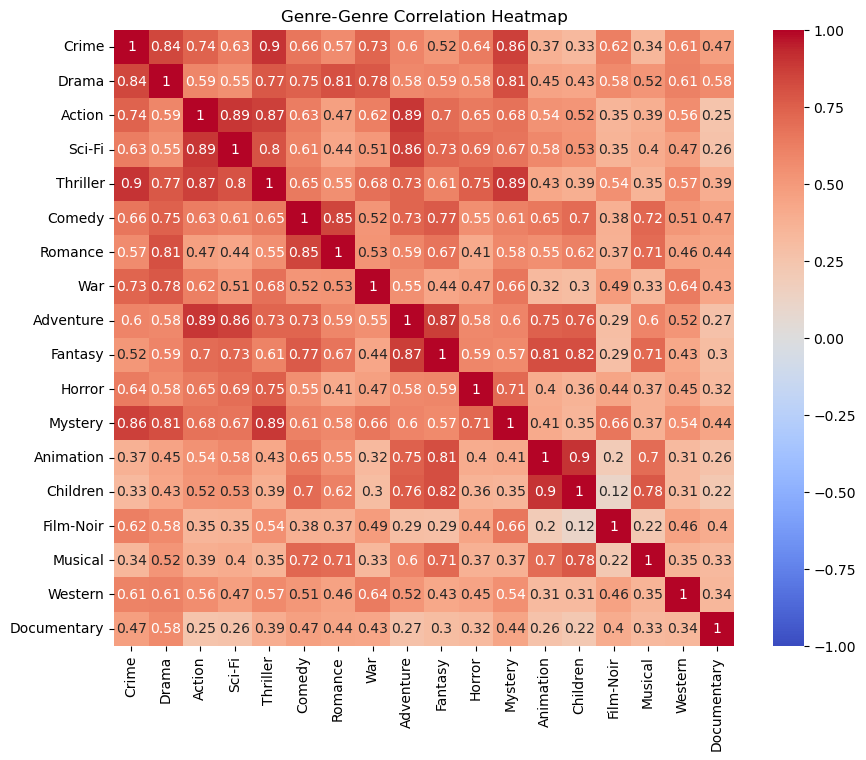

In [20]:
genres_df = pd.read_csv('../data/train/genres.tsv', sep='\t')
genres = genres_df['genre'].unique()

user_data = []
for user in train_df['user'].unique():
    user_genre = {genre: 0 for genre in genres}
    user_df = train_df[train_df['user'] == user]
    for genre in user_df['genre']:
        for g in genre:
            user_genre[g] += 1
    user_data.append(user_genre)

df = pd.DataFrame(user_data, columns=genres)

genre_correlation = df.corr(method='spearman')
# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(genre_correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Genre-Genre Correlation Heatmap")
plt.show()

In [21]:
df.head()

,Crime,Drama,Action,Sci-Fi,Thriller,Comedy,Romance,War,Adventure,Fantasy,Horror,Mystery,Animation,Children,Film-Noir,Musical,Western,Documentary
0,33,112,167,176,130,99,44,12,133,67,58,25,50,53,2,11,1,5
1,9,66,23,23,10,106,55,5,58,34,0,6,40,57,0,22,4,0
2,20,62,3,2,9,28,25,9,3,3,2,7,1,1,1,2,4,1
3,21,41,22,8,16,40,17,5,21,14,6,5,5,9,0,2,1,0
4,12,24,92,49,36,49,10,5,94,47,7,9,32,44,0,0,6,2
